# HOGexpr

*HOGexpr* computes a signal, which can works as input in a specific system. It takes as input the pulses start, pulses duration and experiment duration in minutes. The latter is a constant, while the others are vectors and they have to be the same length. From this function one gets three different signals or profiles. Each of these can be used as a system input. The first one is a step signal that can perform as a valve would do in an experiment. The second one is similar to the previous want but it is deleyed 3 units of time. This functions represents how a stimulus has a delay when it is seen in the biological system. The last one is a signal defined by a differential equation model. The model parameters are specific  for a specific biological process.

In [21]:
#packages required
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

**Defining pulses applied throughout the system**

In [22]:
#experiment duration
tend = np.array([100], float)

#vectors to define pulses start and duration
ton = np.array([1, 5], float)
tdur = np.array([3, 3], float)

**Compute system input**

Process to create step signal that works as a shock valve

Time vector: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100.]
Step Signal: [0. 0. 1. 1. 0. 0. 1. 1. 0. 0.]
Time Signal: [  0.   1.   1.   4.   4.   5.   5.   8.   8. 100.]


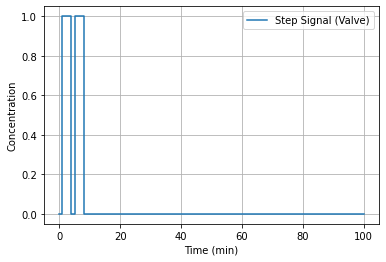

In [23]:
#time vector
cell_time = np.linspace(0,int(tend),int(tend) + 1)
print("Time vector:", cell_time)

### SHOCK VALVE ###
#checks that pulses start are greater than 0
#checks that pulses start are smaller than experiment duration
vton = np.where((ton >= 0) & (ton < tend))

ton = ton[vton]
tdur = tdur[vton]

#checks that pulses duration does not overlap between them
for i in range(len(ton) - 1):
    if ton[i]+tdur[i] > ton[i+1]:
        print("Pulses overlap")

#time and signal initial values
t0 = np.array([0], float)
u0 = np.array([0], float)

#sets "HIGH" in each pulses start
uon = ton*0 + 1

#sets "HIGH" in each pulses end
toff = ton + tdur
uoff = 0*toff + 1

#at the same time when pulses start, the signal is set as "LOW"
tpre = ton
upre = 0*tpre

#at the same time when pulses end, the signal is set as "LOW"
tpos = toff
upos = 0*tpos

#pulses final state
if toff[-1] > tend:
    uend = np.array([uoff[-1]])
else:
    uend = np.array([0], float)

#concatenation of each set time instants and their respective states during 
#experiment
tValve = np.concatenate((t0, tpre, ton, toff, tpos, tend))
uValve = np.concatenate((u0, upre, uon, uoff, upos, uend))

#finds indexes to sort vector ascendingly
ind = np.argsort(tValve)

#takes indexes to sort time vector with its corresponding signal states
tValve = tValve[ind]
uValve = uValve[ind]

#checks and removes any time instant greater that duration experiment
nonv = np.where(tValve > tend[0])

tValve = np.delete(tValve, nonv)
uValve = np.delete(uValve, nonv)

#step signal and time array
t_u_Valve = np.vstack((tValve,uValve))
print("Step Signal:", t_u_Valve[1])
print("Time Signal:", t_u_Valve[0])

plt.figure()
plt.plot(t_u_Valve[0], t_u_Valve[1], label="Step Signal (Valve)")
plt.legend(loc='best')
plt.ylabel('Concentration')
plt.xlabel('Time (min)')
plt.grid()
plt.show()

Then, the step signal is deleyed. This is take into account the lag between the pulse start and the moment when it is seen by the biological system. e.g. in a chamber.

Deleyed Step Signal: [0.   0.   1.   1.   0.75 1.   1.   1.   0.75 0.5  0.25 0.   0.  ]
Time Vector: [  0.   3.   4.   6.   7.   8.   9.  10.  11.  12.  13.  14. 100.]


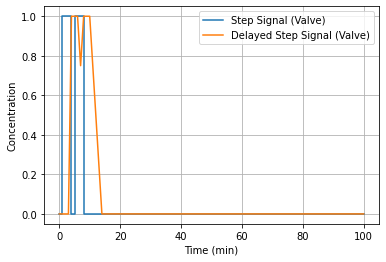

In [24]:
###     CHAMBER   ####################################################
#delay at the beginnig
ton = ton + 3

#profile evolution of the the shock in the chamber
#the "HIGH"s and "LOW"s are set just like it was done with the step signals
uon = ton*0 + 1

#"HIGH" values upon the pulse end. It rests one unit of time due to exponetial
#descending at the end of the signal in the chamber
toff = ton + tdur - 1
uoff = 0*toff + 1

#in camera, it is set "LOW" one instant of time before the pulse
tpre = ton - 1
upre = 0*tpre

#profile decays exponetially in four instants of time
tpos1 = toff + 1
upos1 = tpos1*0 + 0.75

tpos2 = toff + 2
upos2 = tpos2*0 + 0.5

tpos3 = toff + 3
upos3 = tpos3*0 + 0.25

tpos4 = toff + 4
upos4 = tpos4*0

#processing of vector to avoid some overlaping at the start and end vector.

#temporal time and signal vectors
temp0 = np.concatenate((tpos1, tpos2, tpos3, tpos4))
utemp0 = np.concatenate((upos1, upos2, upos3, upos4))

#compares later time instants and pulse start. So, it keeps "High" if there is overlaping 
for i in range(0, len(uon) - 1):
    tempt = temp0[i::(len(uon))]
    
    for j in range(0,4):
        if tempt[j] > ton[i+1]:
            if j == 0:
                upos1[i] = 1
            elif j == 1:
                upos2[i] = 1
            elif j == 2:
                upos3[i] = 1
            elif j == 3:
                upos4[i] = 1
    #end for j
#end for i 

#processing to avoid that pulse ending overlap with the start of the next pulse
for i in range(0, len(uon) - 1):
    tempt = temp0[i::(len(uon))]
    tempu = utemp0[i::(len(uon))]
    
    for j in range(0,4):
        if tpre[i+1] == tempt[j]:
            upre[i+1] = tempu[j]
    #end for j
#end for i

#attaches final value
if toff[-1] > tend:
    uend = np.array([uoff[-1]])
else:
    uend = np.array([0], float)

#concatenates time instants and signal states 
tChamber = np.concatenate((t0, tpre, ton, toff, tpos1, tpos2, tpos3, tpos4, tend))
uChamber = np.concatenate((u0, upre, uon, uoff, upos1, upos2, upos3, upos4, uend))

#sort time instants ascendingly and takes index with no repetition
uniq, ind = np.unique(tChamber, return_index=True)

#from indexes takes state values and corresponding time instants
tChamber = tChamber[ind]
uChamber = uChamber[ind]

#checks and removes time instants that are greater that experiment duration
nonc = np.where(tChamber > tend[0])

tChamber = np.delete(tChamber, nonc)
uChamber = np.delete(uChamber, nonc)

#deley signal array
t_u_Chamber = np.vstack((tChamber,uChamber))
print("Deleyed Step Signal:", t_u_Chamber[1])
print("Time Vector:", t_u_Chamber[0])

plt.figure()
plt.plot(t_u_Valve[0], t_u_Valve[1], label="Step Signal (Valve)")
plt.plot(t_u_Chamber[0], t_u_Chamber[1], label="Delayed Step Signal (Valve)")
plt.legend(loc='best')
plt.ylabel('Concentration')
plt.xlabel('Time (min)')
plt.grid()
plt.show()

If it is needed one can create a signal from a model. The signal takes as input the signals computed before.

HOG vector: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.59146301e-01 3.62163180e-01 4.03114848e-01 3.54607577e-01
 4.00111326e-01 4.18200146e-01 4.25390916e-01 3.63462849e-01
 2.74058376e-01 1.73731371e-01 6.90623983e-02 2.74539706e-02
 1.09136228e-02 4.33843481e-03 1.72463787e-03 6.85588226e-04
 2.72538899e-04 1.08345211e-04 4.30756920e-05 1.71269540e-05
 6.81147809e-06 2.70913159e-06 1.07233785e-06 4.23620259e-07
 1.66847736e-07 6.57572553e-08 2.59159282e-08 1.02138530e-08
 4.02542921e-09 1.58647983e-09 6.25254317e-10 2.46421525e-10
 9.71181481e-11 3.82755964e-11 1.50849327e-11 5.94517495e-12
 2.34307270e-12 9.23435919e-13 3.63938208e-13 1.43432789e-13
 5.65287201e-14 2.22786971e-14 8.78032047e-15 3.46043663e-15
 1.36380225e-15 5.37491854e-16 2.11832389e-16 8.34858456e-17
 3.29028378e-17 1.29674296e-17 5.11063052e-18 2.01416540e-18
 7.93808695e-19 3.12850359e-19 1.23298435e-19 4.85935448e-20
 1.91513646e-20 7.54781078e-21 2.97469495e-21 1.17236821e-21
 4.62046628e

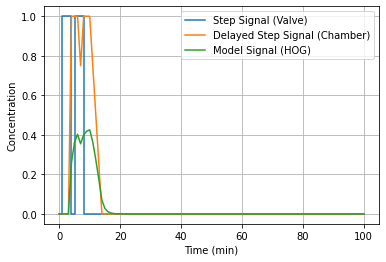

In [25]:
### Example: HOG expresion ###
u = np.interp(cell_time, tChamber, uChamber)

#HOG model
#parameters are specific for this model
def modelHOG(z,t,u):
    hog = z[0]
    dydt = 0.3968*u - 0.9225*hog
    return dydt

#initial values of HOG
hog0 = 0.0

#creates a vector to storege HOG values
hog = np.zeros(len(cell_time))
hog[0] = hog0

#solves differential equation. Each iteratin is a time instant
for i in range(1,int(tend) + 1):
    tspan = [cell_time[i-1], cell_time[i]]
    
    z = odeint(modelHOG,hog0,tspan,args=(u[i],))
    
    hog[i] = z[1]
    hog0 = z[1]
#end for i

print("HOG vector:", hog)
################################
plt.figure()
plt.plot(t_u_Valve[0], t_u_Valve[1], label="Step Signal (Valve)")
plt.plot(t_u_Chamber[0], t_u_Chamber[1], label="Delayed Step Signal (Chamber)")
plt.plot(cell_time, hog, label='Model Signal (HOG)')
plt.legend(loc='best')
plt.ylabel('Concentration')
plt.xlabel('Time (min)')
plt.grid()
plt.show()